# Exercises - GEO4902-02 - Data Assimilation

[Save as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 02-01 -  Analyse the impact of the upper air data assimilation

In [2]:
# import packages
import xarray as xr
import math
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm

#### Fill in the dates and hours for the exercise

In [3]:
year =  '2024'
day  =  '20'
month = '09'

hour_1  ='00'
hour_2  ='03'

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_det_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_det_2_5km_'+year+month+day+'T'+hour_2+'Z.nc'
forecast_2 = xr.open_dataset(url)

### Find a specific point and plot the forecast. 
###### Note AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work:

In [5]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    x=int(x)
    y=int(y)
   
    return (x,y)

In [6]:
[y_loc,x_loc] = findindex(forecast_1['latitude'],forecast_1['longitude'],78.24,15.46) # For example for Longyearbyen

/tmp/ipykernel_7692/4093572236.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/tmp/ipykernel_7692/4093572236.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


#### For example temperature forecasts at a specific model level

In [29]:
mlevel=64
tml_point_forecast_1 = forecast_1['air_temperature_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)
tml_point_forecast_2 = forecast_2['air_temperature_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)

Text(0.5, 1.0, 'Longyearbyen Temperature Forecast')

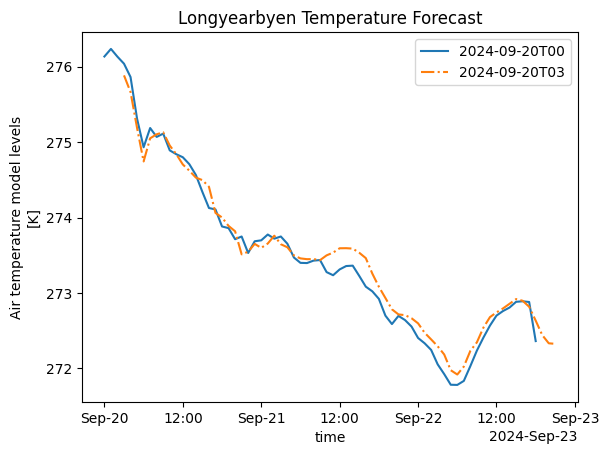

In [30]:
tml_point_forecast_1.plot.line(x='time', linestyle='-', label=(np.datetime_as_string(tml_point_forecast_1.time.isel(time=0), unit='h')))
tml_point_forecast_2.plot.line(x='time', linestyle='-.', label=(np.datetime_as_string(tml_point_forecast_2.time.isel(time=0), unit='h')))
plt.legend()
plt.title("Longyearbyen Temperature Forecast")

2 additional variables relevant to a weather forecast. 

Text(0.5, 1.0, 'Longyearbyen Humidity Forecast')

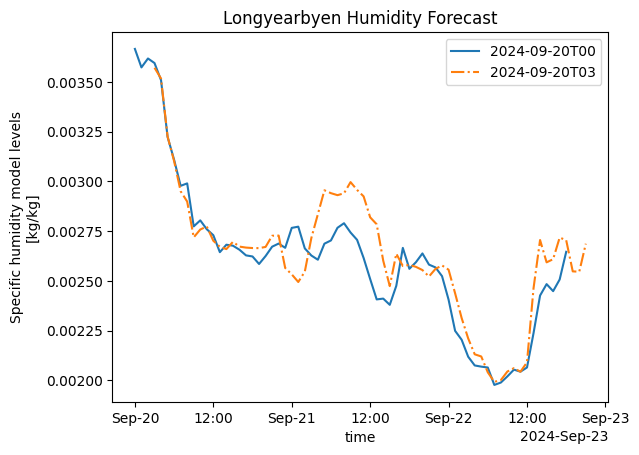

In [14]:
mlevel=64
hml_point_forecast_1 = forecast_1['specific_humidity_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)
hml_point_forecast_2 = forecast_2['specific_humidity_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)

hml_point_forecast_1.plot.line(x='time', linestyle='-', label=(np.datetime_as_string(hml_point_forecast_1.time.isel(time=0), unit='h')))
hml_point_forecast_2.plot.line(x='time', linestyle='-.', label=(np.datetime_as_string(hml_point_forecast_2.time.isel(time=0), unit='h')))
plt.legend()
plt.title("Longyearbyen Humidity Forecast")

Text(0.5, 1.0, 'Longyearbyen Wind Forecast')

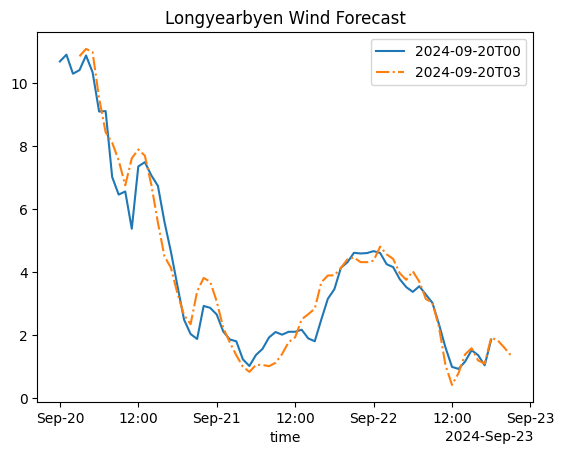

In [17]:
mlevel=64
xwml_point_forecast_1 = forecast_1['x_wind_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)
xwml_point_forecast_2 = forecast_2['x_wind_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)


ywml_point_forecast_1 = forecast_1['y_wind_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)
ywml_point_forecast_2 = forecast_2['y_wind_ml'].isel(hybrid=mlevel, y = y_loc, x=x_loc)

wml_point_forecast_1 = np.sqrt(xwml_point_forecast_1**2 + ywml_point_forecast_1**2)
wml_point_forecast_2 = np.sqrt(xwml_point_forecast_2**2 + ywml_point_forecast_2**2)

wml_point_forecast_1.plot.line(x='time', linestyle='-', label=(np.datetime_as_string(xwml_point_forecast_1.time.isel(time=0), unit='h')))
wml_point_forecast_2.plot.line(x='time', linestyle='-.', label=(np.datetime_as_string(xwml_point_forecast_2.time.isel(time=0), unit='h')))
plt.legend()
plt.title("Longyearbyen Wind Forecast")

### Plot forecast on a map

In this case the background $x_B$ is the previously initialized forecast and $x_A$ is the newer one with new assimilated data.

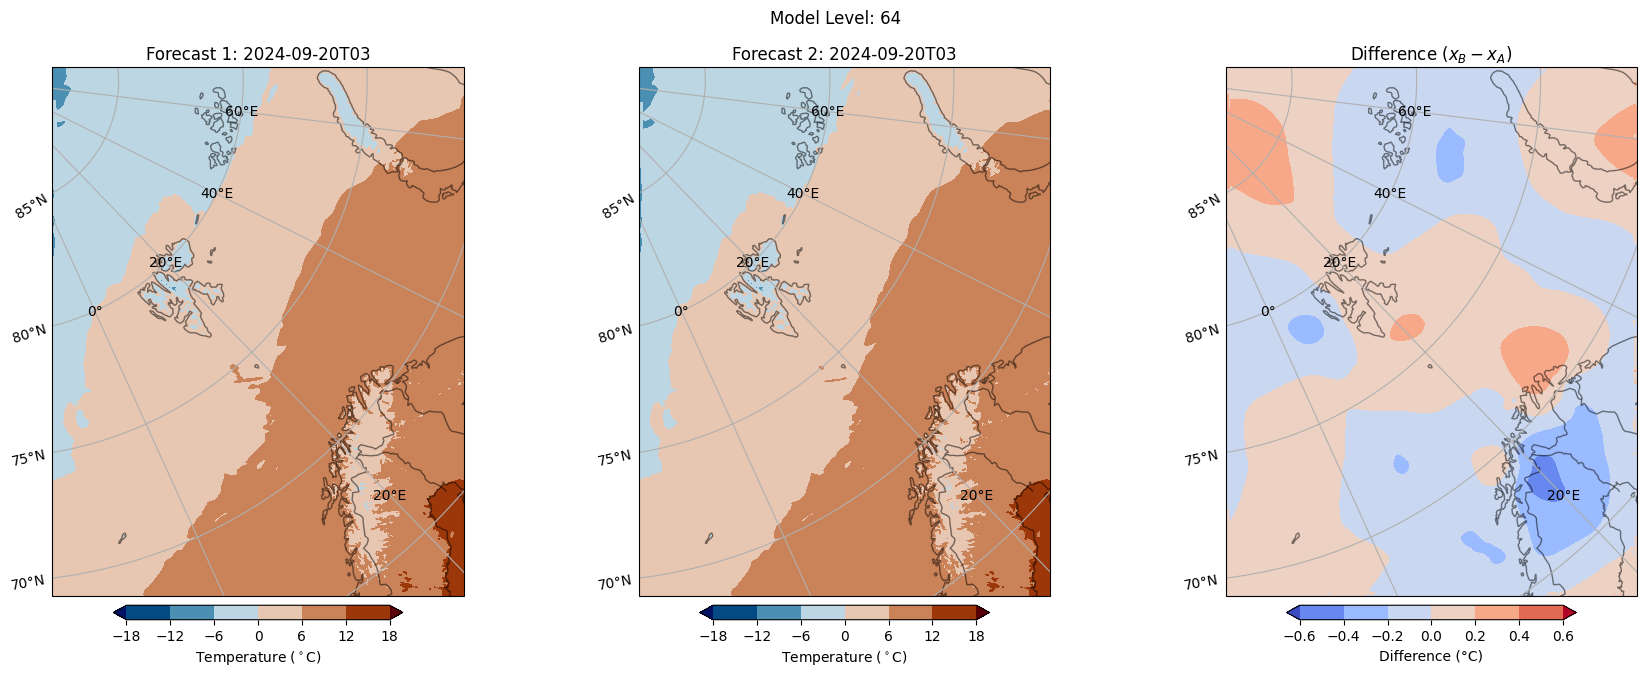

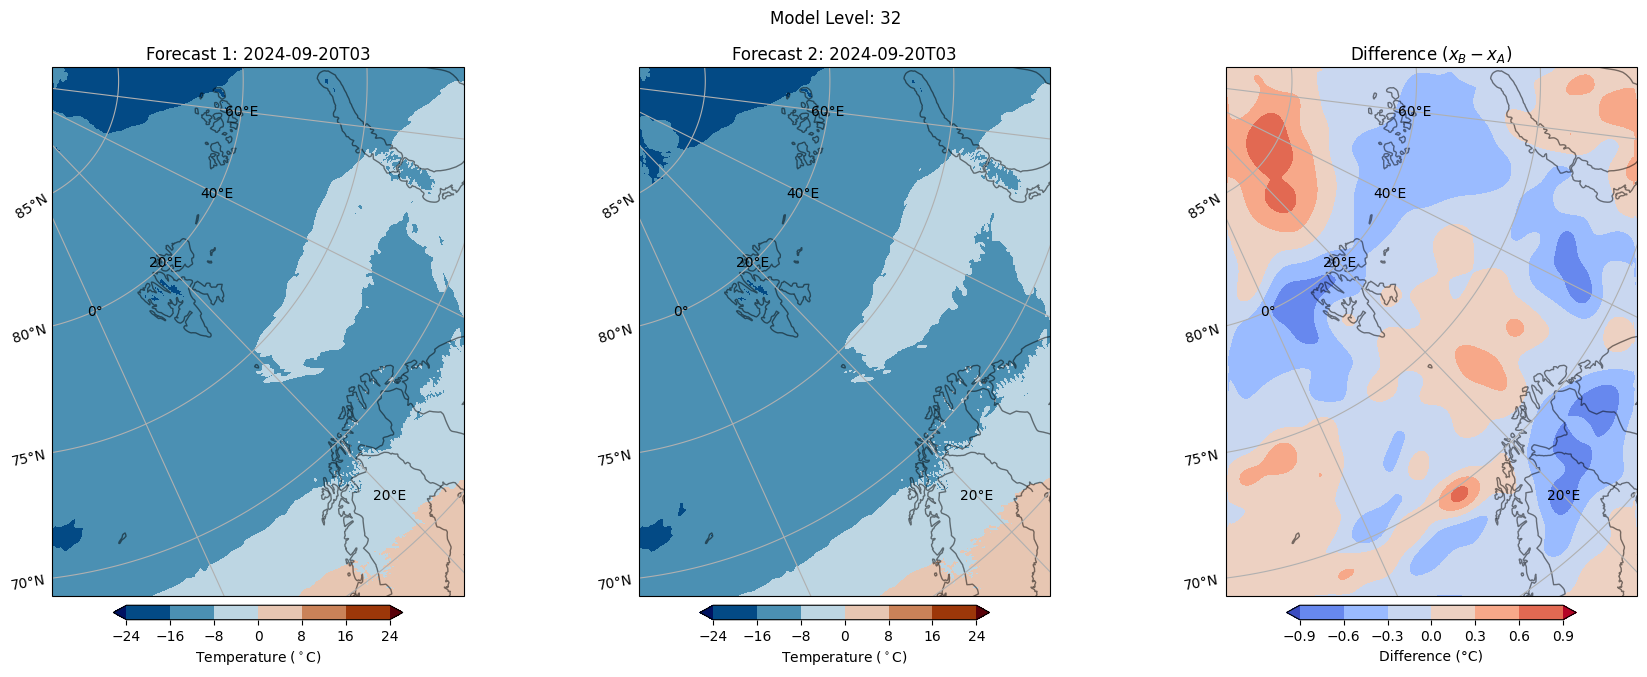

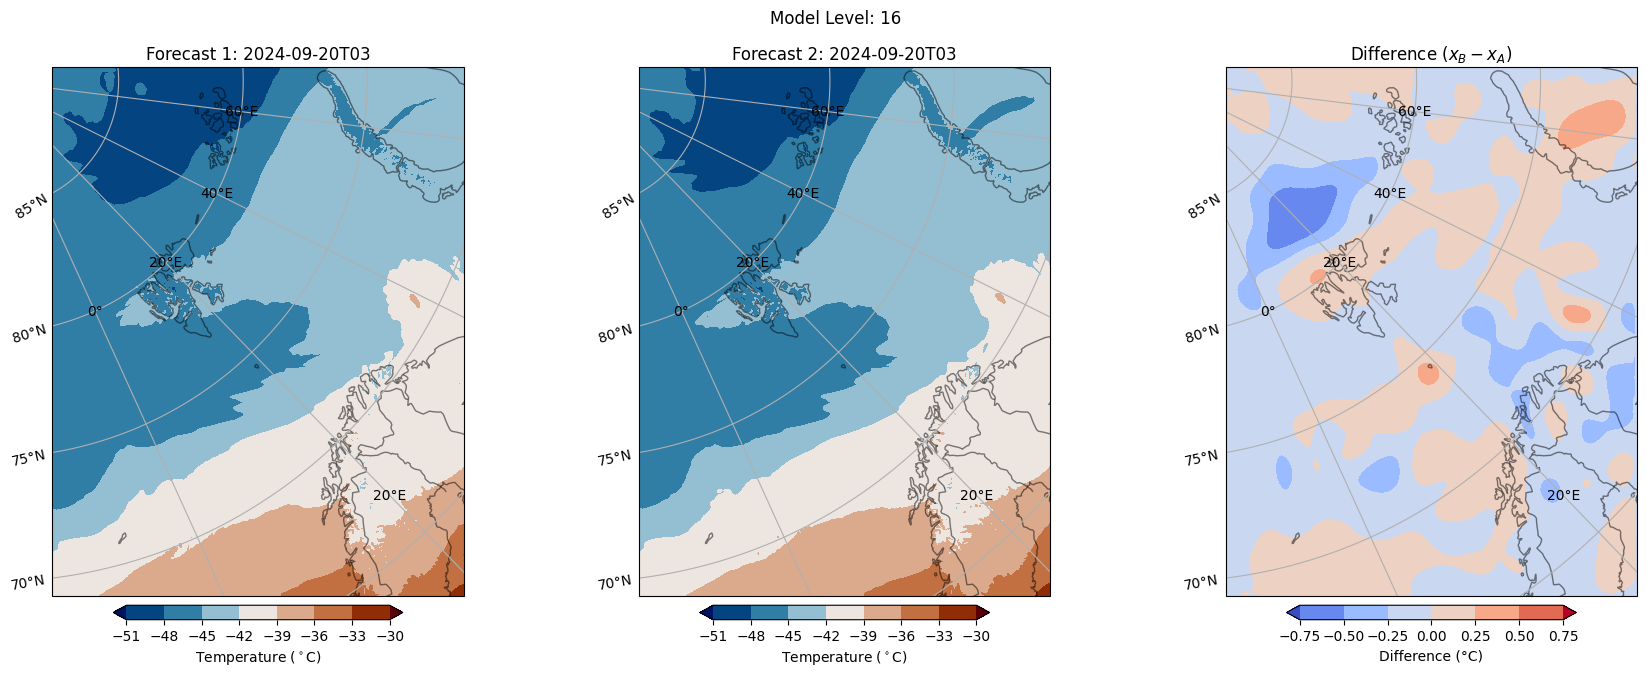

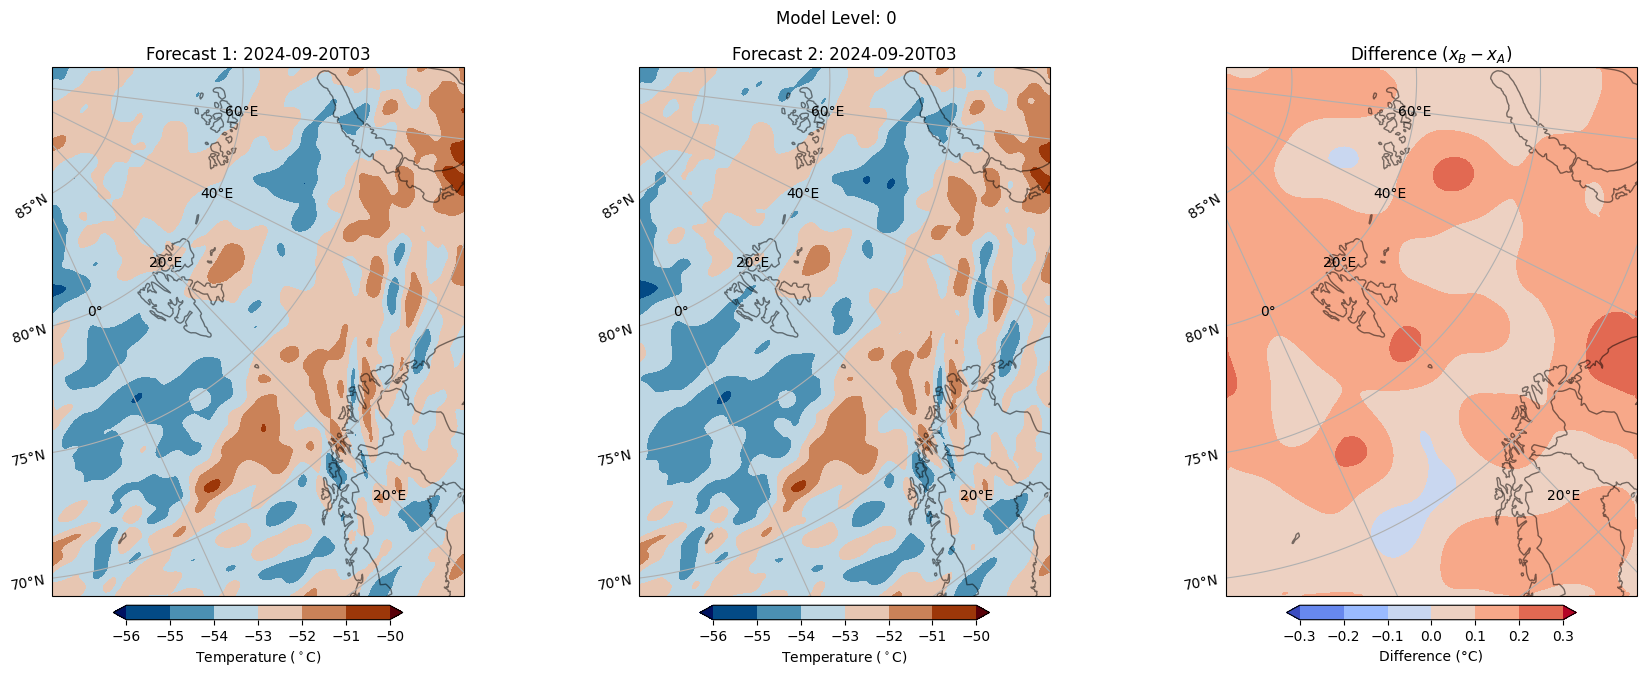

In [11]:
mlevels= [64, 32, 16, 0]
timestep_1=3
timestep_2=0

projection = cy.crs.LambertConformal(central_longitude =forecast_1.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =forecast_1.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = forecast_1.projection_lambert.standard_parallel)

for mlevel in mlevels:
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': projection}, figsize=[18, 7.2])

    # Plot cosmetics (applies to all axes)
    for ax in axes:
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.add_feature(cy.feature.BORDERS, alpha=0.5)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

    # Plot forecast_1
    (forecast_1['air_temperature_ml'].isel(time=timestep_1, hybrid=mlevel) - 273.15).plot.contourf(
        ax=axes[0], 
        x='longitude', 
        y='latitude', 
        cmap=cm.vik, 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'Temperature ($^\circ$C)', 'shrink':0.5, 'pad':0.015}
    )
    axes[0].set_title(f"Forecast 1: {np.datetime_as_string(forecast_1.time.isel(time=timestep_1), unit='h')}")

    # Plot forecast_2 for the same timestep
    (forecast_2['air_temperature_ml'].isel(time=timestep_2, hybrid=mlevel) - 273.15).plot.contourf(
        ax=axes[1], 
        x='longitude', 
        y='latitude', 
        cmap=cm.vik, 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'Temperature ($^\circ$C)', 'shrink':0.5, 'pad':0.015}
    )
    axes[1].set_title(f"Forecast 2: {np.datetime_as_string(forecast_2.time.isel(time=timestep_2), unit='h')}")

    # Plot the difference (x_B - x_A) for the same timestep
    difference = (forecast_1['air_temperature_ml'].isel(time=timestep_1, hybrid=mlevel) -
                forecast_2['air_temperature_ml'].isel(time=timestep_2, hybrid=mlevel))

    (difference).plot.contourf(
        ax=axes[2], 
        x='longitude', 
        y='latitude', 
        cmap='coolwarm', 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'Difference (°C)', 'shrink':0.5, 'pad':0.015}
    )
    axes[2].set_title("Difference ($x_B - x_A$)")
    plt.suptitle(f'Model Level: {mlevel}')
    plt.tight_layout()
    plt.show()

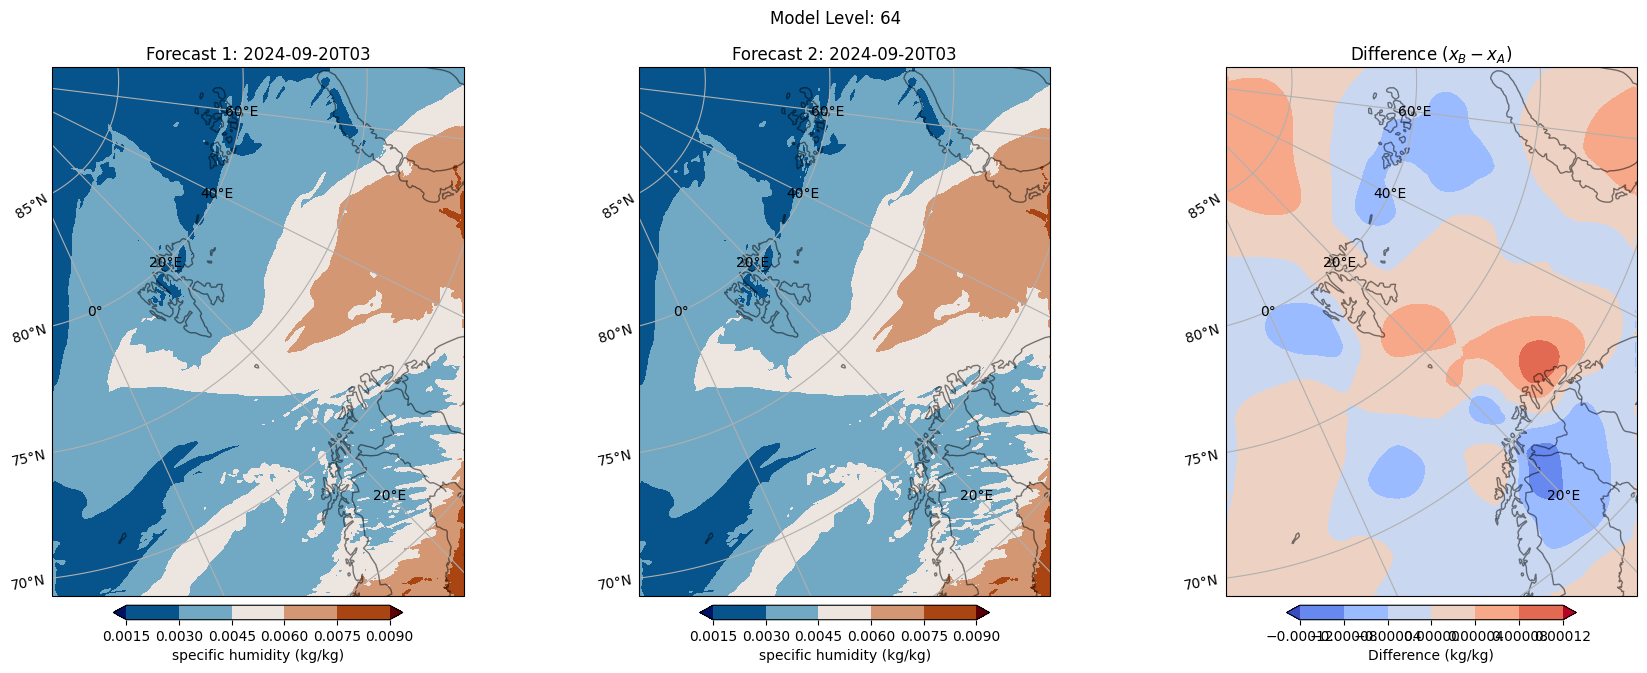

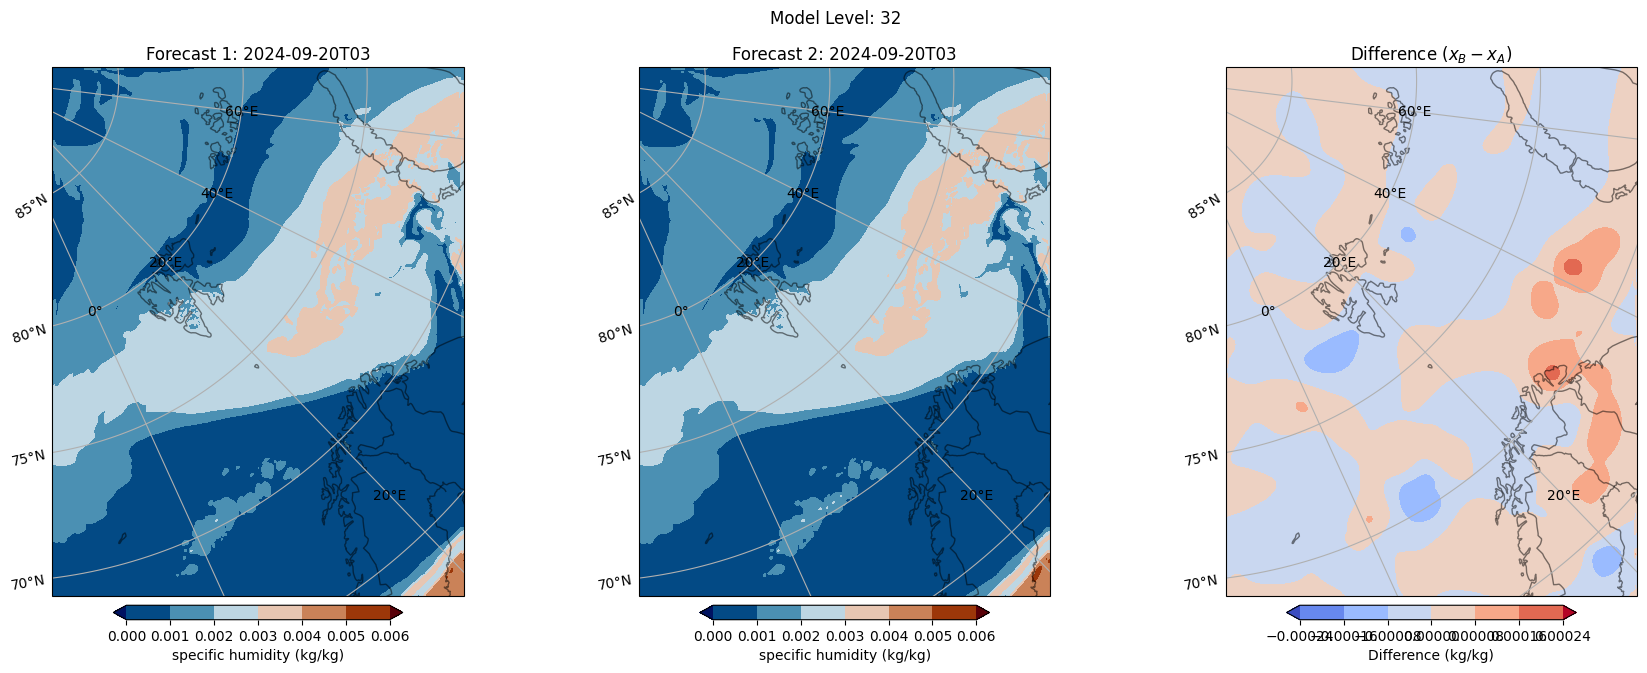

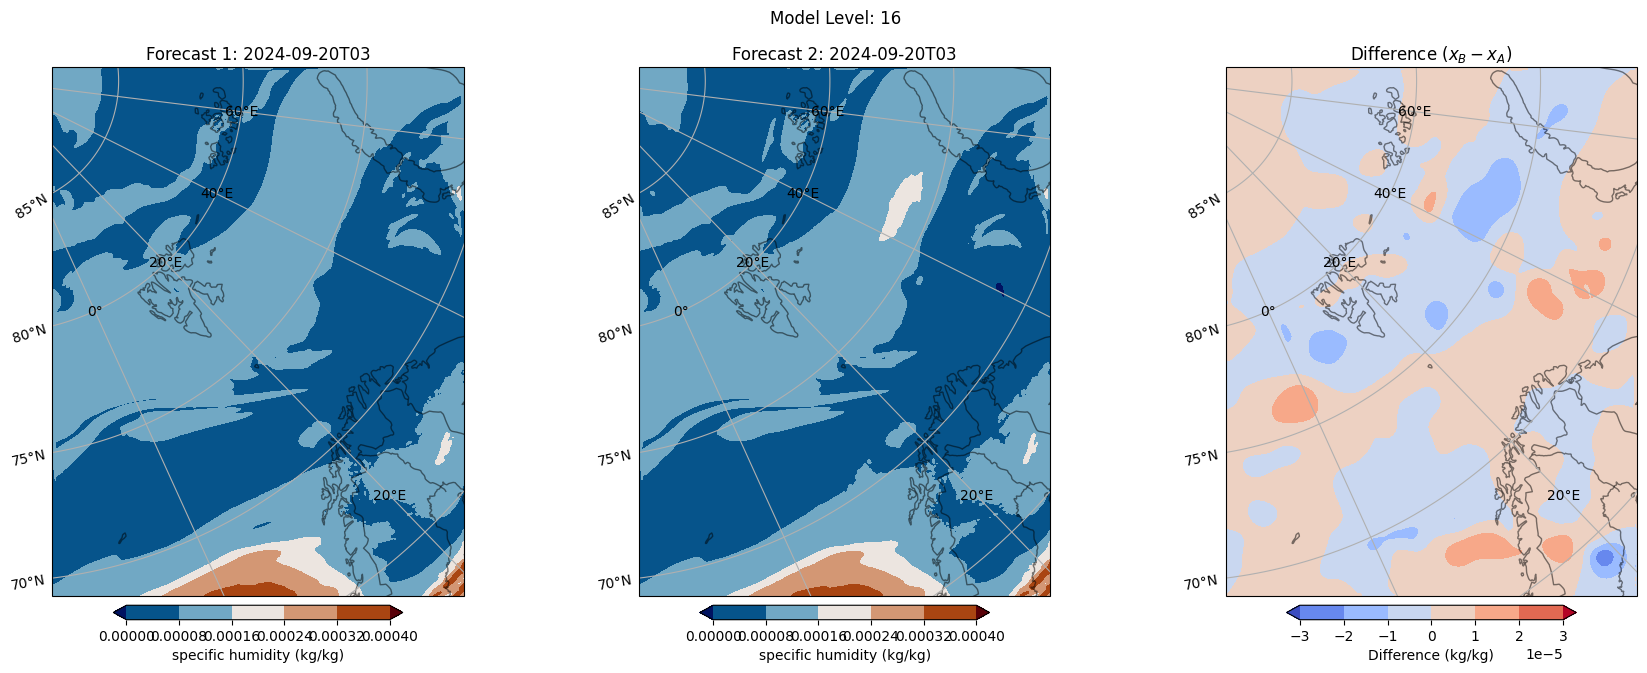

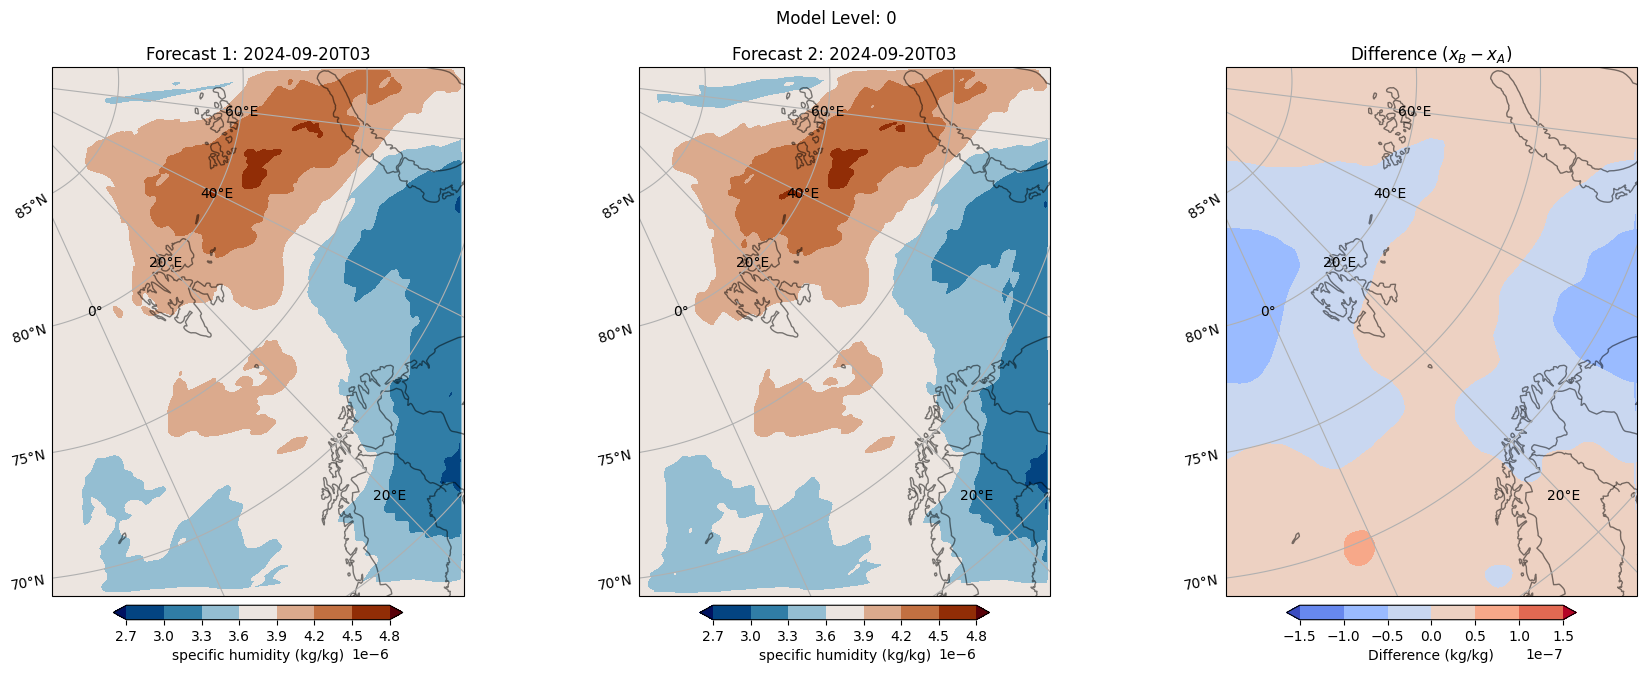

In [20]:
mlevels= [64, 32, 16, 0]
timestep_1=3
timestep_2=0

projection = cy.crs.LambertConformal(central_longitude =forecast_1.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =forecast_1.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = forecast_1.projection_lambert.standard_parallel)

for mlevel in mlevels:
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': projection}, figsize=[18, 7.2])

    # Plot cosmetics (applies to all axes)
    for ax in axes:
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.add_feature(cy.feature.BORDERS, alpha=0.5)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

    # Plot forecast_1
    (forecast_1['specific_humidity_ml'].isel(time=timestep_1, hybrid=mlevel)).plot.contourf(
        ax=axes[0], 
        x='longitude', 
        y='latitude', 
        cmap=cm.vik, 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'specific humidity (kg/kg)', 'shrink':0.5, 'pad':0.015}
    )
    axes[0].set_title(f"Forecast 1: {np.datetime_as_string(forecast_1.time.isel(time=timestep_1), unit='h')}")

    # Plot forecast_2 for the same timestep
    (forecast_2['specific_humidity_ml'].isel(time=timestep_2, hybrid=mlevel)).plot.contourf(
        ax=axes[1], 
        x='longitude', 
        y='latitude', 
        cmap=cm.vik, 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'specific humidity (kg/kg)', 'shrink':0.5, 'pad':0.015}
    )
    axes[1].set_title(f"Forecast 2: {np.datetime_as_string(forecast_2.time.isel(time=timestep_2), unit='h')}")

    # Plot the difference (x_B - x_A) for the same timestep
    difference = (forecast_1['specific_humidity_ml'].isel(time=timestep_1, hybrid=mlevel) -
                forecast_2['specific_humidity_ml'].isel(time=timestep_2, hybrid=mlevel))

    (difference).plot.contourf(
        ax=axes[2], 
        x='longitude', 
        y='latitude', 
        cmap='coolwarm', 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'Difference (kg/kg)', 'shrink':0.5, 'pad':0.015}
    )
    axes[2].set_title("Difference ($x_B - x_A$)")
    plt.suptitle(f'Model Level: {mlevel}')
    plt.tight_layout()
    plt.show()

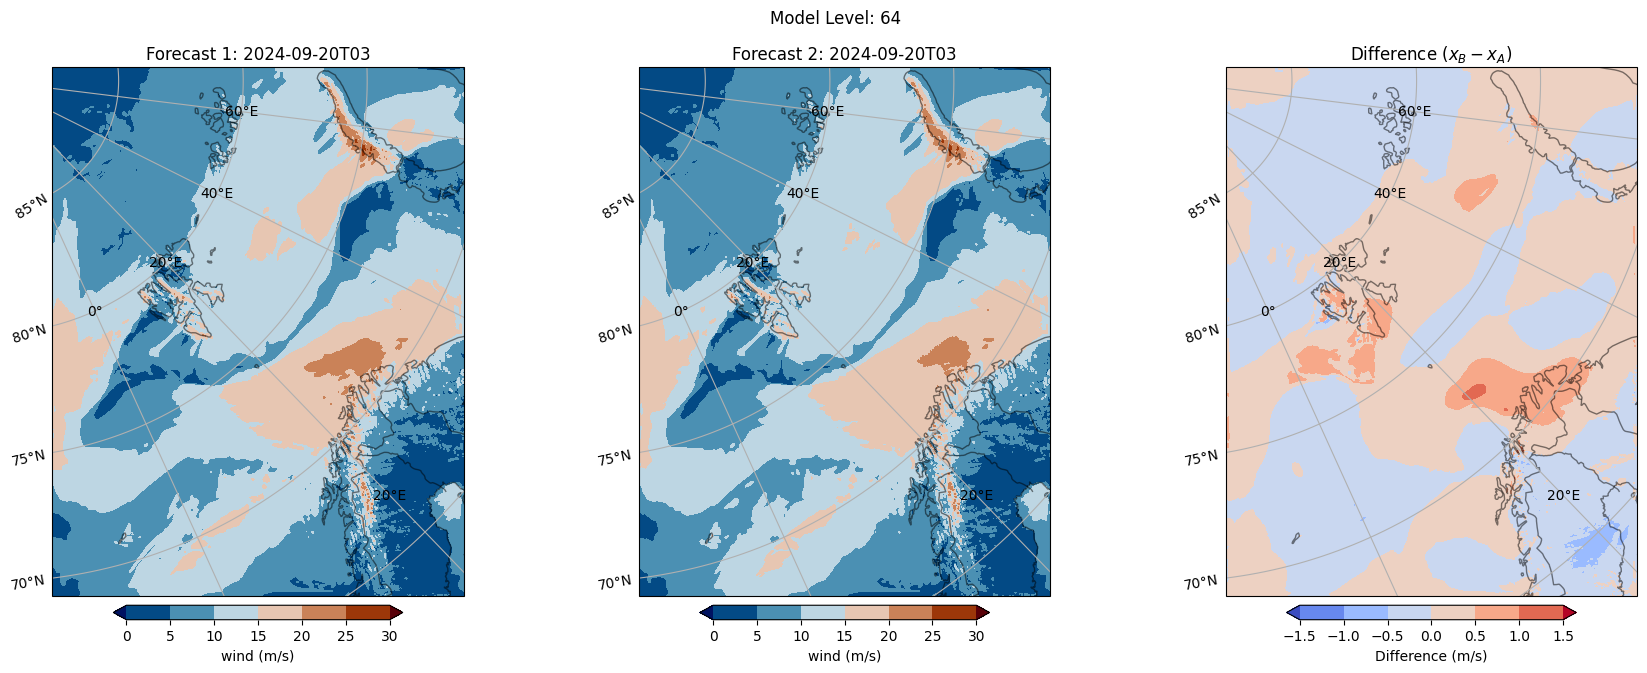

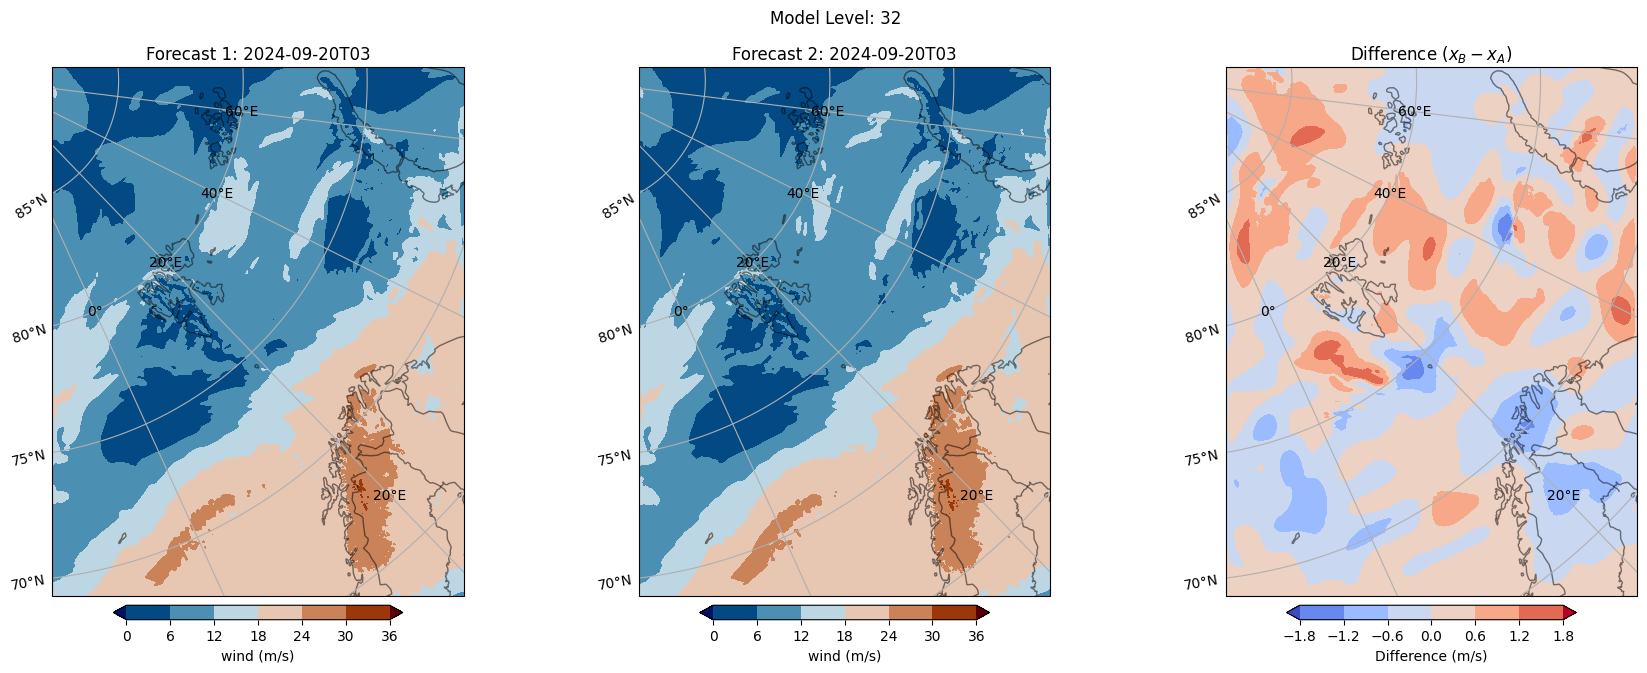

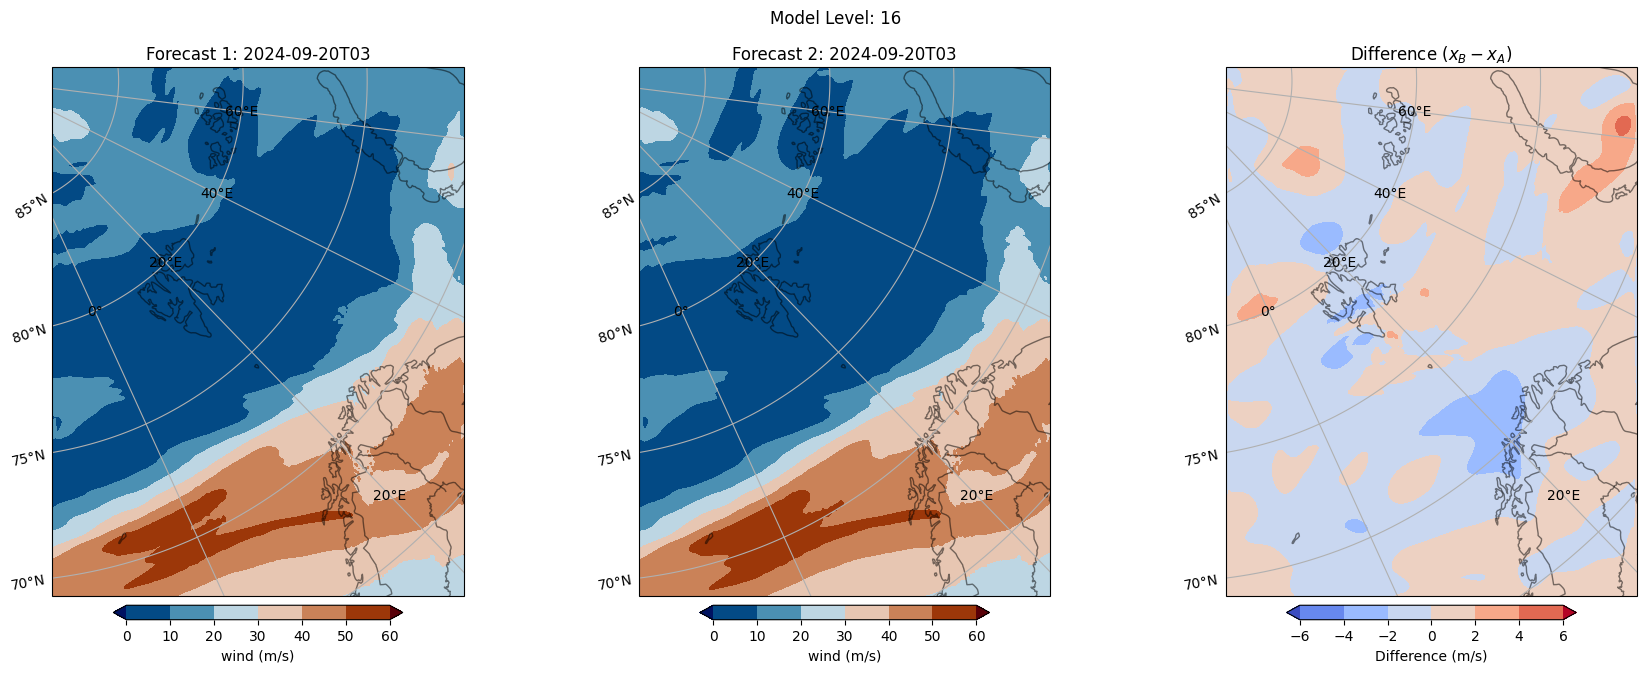

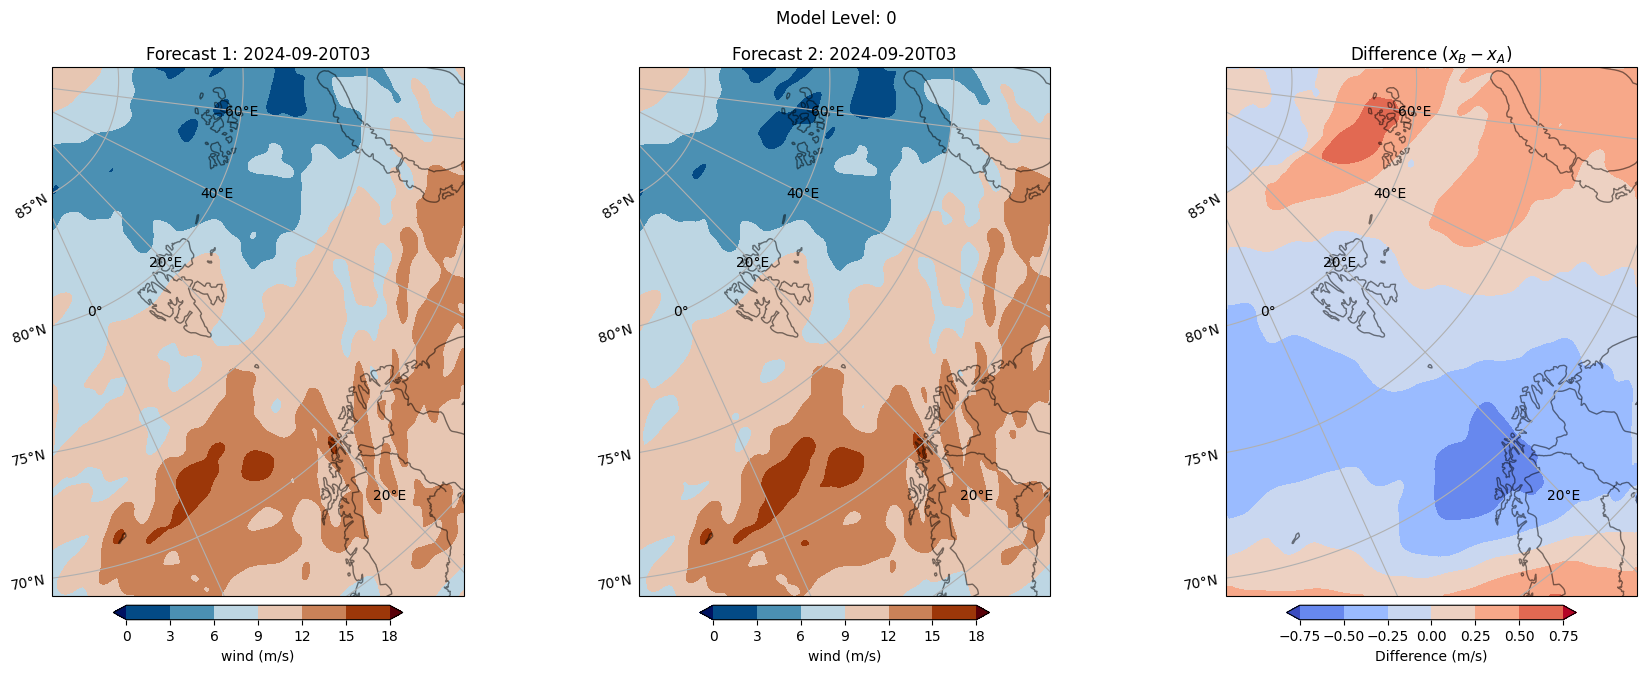

In [24]:
mlevels= [64, 32, 16, 0]
timestep_1=3
timestep_2=0

projection = cy.crs.LambertConformal(central_longitude =forecast_1.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =forecast_1.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = forecast_1.projection_lambert.standard_parallel)

for mlevel in mlevels:
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': projection}, figsize=[18, 7.2])

    # Plot cosmetics (applies to all axes)
    for ax in axes:
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.add_feature(cy.feature.BORDERS, alpha=0.5)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

    # Plot forecast_1
    xw1 = forecast_1['x_wind_ml'].isel(time=timestep_1, hybrid=mlevel)
    yw1 = forecast_1['y_wind_ml'].isel(time=timestep_1, hybrid=mlevel)
    w1 = np.sqrt(xw1**2 + yw1**2)

    w1.plot.contourf(
        ax=axes[0], 
        x='longitude', 
        y='latitude', 
        cmap=cm.vik, 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'wind (m/s)', 'shrink':0.5, 'pad':0.015}
    )
    axes[0].set_title(f"Forecast 1: {np.datetime_as_string(forecast_1.time.isel(time=timestep_1), unit='h')}")

    # Plot forecast_2 for the same timestep
    xw2 = forecast_2['x_wind_ml'].isel(time=timestep_2, hybrid=mlevel)
    yw2 = forecast_2['y_wind_ml'].isel(time=timestep_2, hybrid=mlevel)
    w2 = np.sqrt(xw2**2 + yw2**2)


    w2.plot.contourf(
        ax=axes[1], 
        x='longitude', 
        y='latitude', 
        cmap=cm.vik, 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'wind (m/s)', 'shrink':0.5, 'pad':0.015}
    )
    axes[1].set_title(f"Forecast 2: {np.datetime_as_string(forecast_2.time.isel(time=timestep_2), unit='h')}")

    # Plot the difference (x_B - x_A) for the same timestep
    difference = w1 - w2
    (difference).plot.contourf(
        ax=axes[2], 
        x='longitude', 
        y='latitude', 
        cmap='coolwarm', 
        extend='both', 
        transform=cy.crs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal', 'label':'Difference (m/s)', 'shrink':0.5, 'pad':0.015}
    )
    axes[2].set_title("Difference ($x_B - x_A$)")
    plt.suptitle(f'Model Level: {mlevel}')
    plt.tight_layout()
    plt.show()